# Performance Analysis

In this notebook we analyze the behavior of the various node coloring algorithms in the ``gcol`` library. Where appropriate, we also make comparisons to similar algorithms from the ``networkx`` library. 

In this analysis, algorithms are evaluated by looking at solution quality and run times. Details on asymptotic algorithm complexity (in terms of big O notation) can be found in ``gcol``'s documentation. Here, all tests are conducted on randomly generated [Erdos-Renyi](https://en.wikipedia.org/wiki/Erdos-Renyi_model) graphs, commonly denoted by $G(n,p)$. These graphs are constructed by taking $n$ nodes and adding an edge between each node pair at random with probability $p$. The expected number of edges in a $G(n,p)$ graph is therefore $\binom{n}{2}p$, while the expected node degree is $(n-1)p$. 

For these tests, we use differing values for $n$ but keep $p$ fixed at $0.5$. This is due to a [result](https://mathoverflow.net/questions/424327/selection-of-an-n-node-graph-at-random) of [Nick Wormald](https://en.wikipedia.org/wiki/Nick_Wormald), who has established that for $n \gtrapprox 30$, a set of randomly constructed $G(n, 0.5)$ graphs can be considered equivalent to a random sample from the population of *all* $n$-node graphs. Note, however, that although this allows us to make general statistical statements about performance, different observations may well be made when executing these algorithms on specifically chosen topologies, such as [scale-free graphs](https://en.wikipedia.org/wiki/Scale-free_network) and [planar graphs](https://en.wikipedia.org/wiki/Planar_graph). Examples of these differences are discussed in this [book](https://link.springer.com/book/10.1007/978-3-030-81054-2).

In the code below, each trial involves generating a set of $G(n,0.5)$ graphs using a range of values of $n$. The results of the algorithms are then written to a Pandas dataframe ``df``, and this data is summarized in charts and pivot tables. Lines in the charts give mean values, while the shaded areas indicate one standard deviation on either side of these means. All results below were found by executing the code on a 3.0 GHtz Windows 11 PC with 16 GB of RAM.

## Differing Node Coloring Strategies

In our first experiment, we compare the different constructive strategies available for node coloring in the ``gcol`` library (namely ``'random'``, ``'welsh_powell'``, ``'dsatur'``, and ``'rlf'``) using $G(n,0.5)$ graphs with values of $n$ between $50$ and $500$. The results are shown in the pivot table and charts below. Further details on these algorithms can be found in ``gcol``'s documentation.

In [1]:
import pandas as pd
import networkx as nx
import gcol
import matplotlib.pyplot as plt
import time

#Carry out the trials and put the results into a list
results = []
nVals = range(50,501,50)
for n in nVals:
    for seed in range(50):
        G = nx.gnp_random_graph(n, 0.5, seed)
        for strategy in ["random", "welsh_powell", "dsatur", "rlf"]:
            start = time.time()
            c = gcol.node_coloring(G, strategy)
            results.append([n, seed, strategy, max(c.values()) + 1, time.time()-start])
            
# Create a pandas dataframe from this list, make a pivot table, and display it
df = pd.DataFrame(results, columns=["n", "seed", "strategy", "cols", "time"])
pivot = df.pivot_table(columns='strategy', aggfunc=['mean','std'], values=['cols','time'], index='n')
display(pivot)

mean                                                           \
           cols                                 time                       
strategy dsatur random    rlf welsh_powell    dsatur    random       rlf   
n                                                                          
50        11.00  12.90  10.60        12.02  0.001126  0.000334  0.004669   
100       18.20  21.36  17.24        19.96  0.003144  0.000055  0.031238   
150       24.84  28.78  23.14        27.04  0.008169  0.000625  0.100434   
200       30.96  36.10  28.96        33.76  0.014932  0.000174  0.238887   
250       37.14  42.56  34.30        40.08  0.019173  0.001935  0.447659   
300       42.72  48.68  39.56        46.24  0.030017  0.002138  0.786219   
350       48.86  54.94  44.82        52.36  0.037244  0.002165  1.193058   
400       54.38  60.82  50.08        58.38  0.047678  0.005056  1.773202   
450       59.74  66.70  54.94        64.12  0.062071  0.003636  2.596551   
500       65.08  72.24  60.06        69.72  0.075578  0.006313  3.614420   

                            std                                             \
                           cols                                       time   
strategy welsh_powell    dsatur    random       rlf welsh_powell    dsatur   
n                                                                            
50           0.000021  0.571429  0.863075  0.534522     0.684821  0.003808   
100          0.000160  0.571429  0.875051  0.591090     0.698687  0.004793   
150          0.000352  0.841767  1.130107  0.606428     1.068281  0.007916   
200          0.001273  0.727310  1.281740  0.698687     0.938083  0.013072   
250          0.000433  0.926041  1.311799  0.677631     1.026983  0.006828   
300          0.001789  1.195911  1.096190  0.674915     1.021404  0.017120   
350          0.002740  0.833238  1.038248  0.774333     1.083456  0.008014   
400          0.003022  0.923392  1.063111  0.633745     1.066943  0.003849   
450          0.004267  1.139459  1.035098  0.711710     1.319245  0.006253   
500          0.005314  0.965528  1.450686  0.711710     1.178723  0.006116   

                                           
                                           
strategy    random       rlf welsh_powell  
n                                          
50        0.002212  0.006797     0.000141  
100       0.000214  0.004788     0.000371  
150       0.003092  0.008025     0.002212  
200       0.001098  0.007489     0.004277  
250       0.005113  0.008536     0.002245  
300       0.004685  0.013414     0.004237  
350       0.005124  0.009833     0.005731  
400       0.007170  0.011331     0.006023  
450       0.006539  0.026104     0.006861  
500       0.007522  0.035249     0.007270

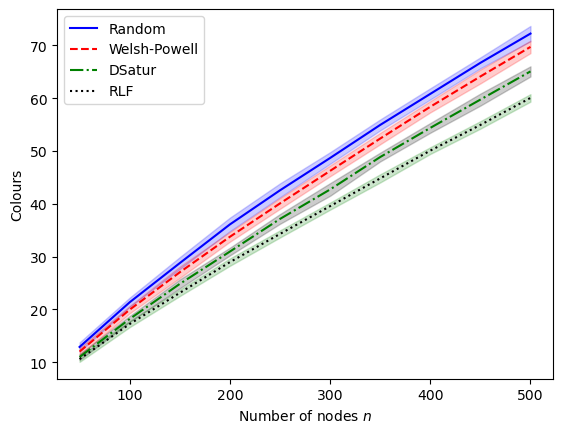

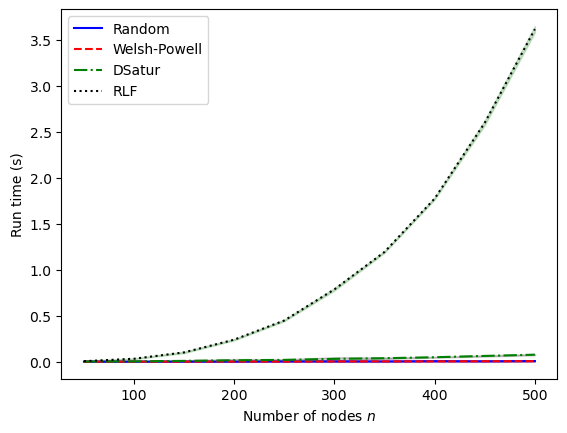

In [2]:
# Now use the pivot table above to make a chart that compares mean solution quality
mean1, SD1 = pivot[("mean","cols","random")], pivot[("std","cols","random")]
mean2, SD2 = pivot[("mean","cols","welsh_powell")], pivot[("std","cols","welsh_powell")]
mean3, SD3 = pivot[("mean","cols","dsatur")], pivot[("std","cols","dsatur")]
mean4, SD4 = pivot[("mean","cols","rlf")], pivot[("std","cols","rlf")]
plt.plot(nVals, mean1, linestyle='-', linewidth=1.5, color="b", label='Random')
plt.fill_between(nVals, mean1-SD1, mean1+SD1, color='b', alpha=0.2)
plt.plot(nVals, mean2, linestyle='--', linewidth=1.5, color="r", label='Welsh-Powell')
plt.fill_between(nVals, mean2-SD2, mean2+SD2, color='r', alpha=0.2)
plt.plot(nVals, mean3, linestyle='-.', linewidth=1.5, color="g", label='DSatur')
plt.fill_between(nVals, mean3-SD3, mean3+SD3, color='k', alpha=0.2)
plt.plot(nVals, mean4, linestyle=':', linewidth=1.5, color="black", label='RLF')
plt.fill_between(nVals, mean4-SD4, mean4+SD4, color='g', alpha=0.2)
plt.xlabel("Number of nodes $n$")
plt.ylabel("Colours")
plt.legend()
plt.show()

# and do the same for mean run times
mean1, SD1 = pivot[("mean","time","random")], pivot[("std","time","random")]
mean2, SD2 = pivot[("mean","time","welsh_powell")], pivot[("std","time","welsh_powell")]
mean3, SD3 = pivot[("mean","time","dsatur")], pivot[("std","time","dsatur")]
mean4, SD4 = pivot[("mean","time","rlf")], pivot[("std","time","rlf")]
plt.plot(nVals, mean1, linestyle='-', linewidth=1.5, color="b", label='Random')
plt.fill_between(nVals, mean1-SD1, mean1+SD1, color='b', alpha=0.2)
plt.plot(nVals, mean2, linestyle='--', linewidth=1.5, color="r", label='Welsh-Powell')
plt.fill_between(nVals, mean2-SD2, mean2+SD2, color='r', alpha=0.2)
plt.plot(nVals, mean3, linestyle='-.', linewidth=1.5, color="g", label='DSatur')
plt.fill_between(nVals, mean3-SD3, mean3+SD3, color='k', alpha=0.2)
plt.plot(nVals, mean4, linestyle=':', linewidth=1.5, color="black", label='RLF')
plt.fill_between(nVals, mean4-SD4, mean4+SD4, color='g', alpha=0.2)
plt.xlabel("Number of nodes $n$")
plt.ylabel("Run time (s)")
plt.legend()
plt.show()

The results above show that the ``random`` and ``welsh-powell`` strategies produce the poorest solutions overall (in terms of the number of colors they use) while the RLF algorithm produces the best. This gap also seems to widen for larger values of $n$. On the other hand, the RLF algorithm has less favorable run times, as shown in the second chart. This is to be expected because the RLF algorithm has a higher complexity than the others. A good compromise seems to be struck by the ``dsatur`` strategy, which features comparatively good solution quality and run times.

## Comparison to NetworkX

The next set of experiments compares the performance of ``gcol``'s local search routines and NetworkX's [interchange coloring routine](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.coloring.greedy_color.html). As a benchmark, we also include ``gcol``'s ``dsatur`` option from earlier, which has also been used to produce the initial solutions for the local search algorithms. For comparative purposes, both of ``gcol``'s local search algorithms (``opt_alg=2`` and ``opt_alg=3``) are used here, and we impose a fixed iteration limit of $n$. The results are collected and displayed in the same manner as the previous example.

mean                                                             \
      cols                                   time                       
alg dsatur networkx opt_alg=2 opt_alg=3    dsatur  networkx opt_alg=2   
n                                                                       
50   11.00    10.58     10.24     10.44  0.001198  0.002848  0.004415   
100  18.20    17.72     16.90     17.10  0.002699  0.011782  0.022187   
150  24.84    24.30     23.04     23.16  0.012574  0.032542  0.047948   
200  30.96    30.52     28.50     28.94  0.015713  0.079482  0.080056   
250  37.14    36.46     34.30     34.42  0.024954  0.139182  0.129421   
300  42.72    42.00     39.46     39.84  0.034277  0.233811  0.192308   
350  48.86    47.98     44.62     45.12  0.036986  0.366410  0.276068   
400  54.38    53.46     49.82     50.16  0.064390  0.511017  0.372623   
450  59.74    58.98     55.00     55.40  0.089714  0.686402  0.470342   
500  65.08    64.46     59.68     60.24  0.146833  0.910533  0.616006   
550  70.44    69.76     64.68     65.22  0.133141  1.241486  0.799239   
600  75.72    74.68     69.36     69.98  0.127430  1.621527  1.015307   

                    std                                                    \
                   cols                                    time             
alg opt_alg=3    dsatur  networkx opt_alg=2 opt_alg=3    dsatur  networkx   
n                                                                           
50   0.004150  0.571429  0.609114  0.476381  0.611455  0.003728  0.005433   
100  0.015837  0.571429  0.671277  0.505076  0.580288  0.005744  0.011038   
150  0.039211  0.841767  0.646813  0.668840  0.680936  0.012057  0.013263   
200  0.068262  0.727310  0.788696  0.580288  0.711710  0.011063  0.023787   
250  0.109929  0.926041  0.885484  0.646813  0.609114  0.018215  0.029630   
300  0.164115  1.195911  0.755929  0.705951  0.680936  0.020489  0.029099   
350  0.232763  0.833238  0.769044  0.602376  0.479796  0.007532  0.024408   
400  0.309454  0.923392  0.973317  0.719694  0.618095  0.026725  0.031725   
450  0.400221  1.139459  0.769044  0.728431  0.808122  0.033389  0.049046   
500  0.522832  0.965528  1.034309  0.683329  0.624663  0.007637  0.058123   
550  0.676384  0.951047  0.959592  0.712569  0.708260  0.042047  0.076402   
600  0.850793  1.161280  1.096190  0.776176  0.684821  0.037837  0.112966   

                         
                         
alg opt_alg=2 opt_alg=3  
n                        
50   0.005995  0.005789  
100  0.012093  0.003045  
150  0.015423  0.007838  
200  0.009535  0.009321  
250  0.013072  0.008136  
300  0.010850  0.010551  
350  0.018478  0.011266  
400  0.026486  0.016676  
450  0.028102  0.020487  
500  0.025956  0.022833  
550  0.034881  0.026771  
600  0.045676  0.035609

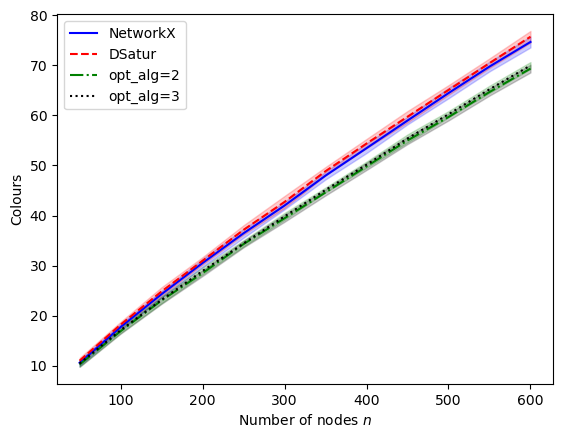

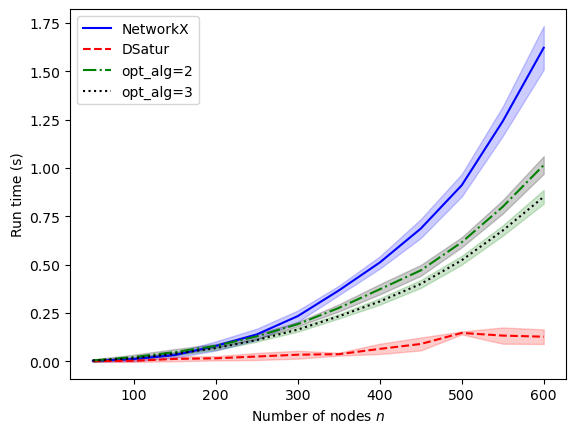

In [3]:
#Carry out the trials and put the results into a list
results = []
nVals = range(50,601,50)
for n in nVals:
    for seed in range(50):
        G = nx.gnp_random_graph(n, 0.5, seed)
        start = time.time()
        c = nx.greedy_color(G, "largest_first", interchange=True)
        results.append([n, seed, "networkx", max(c.values()) + 1, time.time()-start])
        start = time.time()
        c = gcol.node_coloring(G)
        results.append([n, seed, "dsatur", max(c.values()) + 1, time.time()-start])
        start = time.time()
        c = gcol.node_coloring(G, opt_alg=2, it_limit=len(G))
        results.append([n, seed, "opt_alg=2", max(c.values()) + 1, time.time()-start])
        start = time.time()
        c = gcol.node_coloring(G, opt_alg=3, it_limit=len(G))
        results.append([n, seed, "opt_alg=3", max(c.values()) + 1, time.time()-start])
            
# Create a pandas dataframe from this list and make a pivot table
df = pd.DataFrame(results, columns=["n", "seed", "alg", "cols", "time"])
pivot = df.pivot_table(columns='alg', aggfunc=['mean','std'], values=['cols','time'], index='n')
display(pivot)

# Use the pivot table to make charts as before
mean1, SD1 = pivot[("mean","cols","networkx")], pivot[("std","cols","networkx")]
mean2, SD2 = pivot[("mean","cols","dsatur")], pivot[("std","cols","dsatur")]
mean3, SD3 = pivot[("mean","cols","opt_alg=2")], pivot[("std","cols","opt_alg=2")]
mean4, SD4 = pivot[("mean","cols","opt_alg=3")], pivot[("std","cols","opt_alg=3")]
plt.plot(nVals, mean1, linestyle='-', linewidth=1.5, color="b", label='NetworkX')
plt.fill_between(nVals, mean1-SD1, mean1+SD1, color='b', alpha=0.2)
plt.plot(nVals, mean2, linestyle='--', linewidth=1.5, color="r", label='DSatur')
plt.fill_between(nVals, mean2-SD2, mean2+SD2, color='r', alpha=0.2)
plt.plot(nVals, mean3, linestyle='-.', linewidth=1.5, color="g", label='opt_alg=2')
plt.fill_between(nVals, mean3-SD3, mean3+SD3, color='k', alpha=0.2)
plt.plot(nVals, mean4, linestyle=':', linewidth=1.5, color="black", label='opt_alg=3')
plt.fill_between(nVals, mean4-SD4, mean4+SD4, color='g', alpha=0.2)
plt.xlabel("Number of nodes $n$")
plt.ylabel("Colours")
plt.legend()
plt.show()

mean1, SD1 = pivot[("mean","time","networkx")], pivot[("std","time","networkx")]
mean2, SD2 = pivot[("mean","time","dsatur")], pivot[("std","time","dsatur")]
mean3, SD3 = pivot[("mean","time","opt_alg=2")], pivot[("std","time","opt_alg=2")]
mean4, SD4 = pivot[("mean","time","opt_alg=3")], pivot[("std","time","opt_alg=3")]
plt.plot(nVals, mean1, linestyle='-', linewidth=1.5, color="b", label='NetworkX')
plt.fill_between(nVals, mean1-SD1, mean1+SD1, color='b', alpha=0.2)
plt.plot(nVals, mean2, linestyle='--', linewidth=1.5, color="r", label='DSatur')
plt.fill_between(nVals, mean2-SD2, mean2+SD2, color='r', alpha=0.2)
plt.plot(nVals, mean3, linestyle='-.', linewidth=1.5, color="g", label='opt_alg=2')
plt.fill_between(nVals, mean3-SD3, mean3+SD3, color='k', alpha=0.2)
plt.plot(nVals, mean4, linestyle=':', linewidth=1.5, color="black", label='opt_alg=3')
plt.fill_between(nVals, mean4-SD4, mean4+SD4, color='g', alpha=0.2)
plt.xlabel("Number of nodes $n$")
plt.ylabel("Run time (s)")
plt.legend()
plt.show()

It is clear from the above results that the local search algorithms make significant improvements to the solutions provided by the ``dsatur`` strategy, albeit with additional time requirements. The solutions and run times of these local search algorithms are also superior to NetworkX's node coloring routines. Note that further improvements in solution quality might also be found by increasing the iteration limit of the local search algorithms.

## Exact Algorithm Performance

In addition to two local search heuristics, the ``gcol`` library also features an exact, exponential-time algorithm for node coloring, based on backtracking. This algorithm is invoked by setting ``opt_alg=1``. At the start of this algorithm's execution, a large clique $C$ is identified in $G$ using the NetworkX function ``nx.max_clique()``. The nodes of $C$ are then permanently assigned to different colors. The main backtracking algorithm is then executed and only halts only when a solution using $C$ colors has been identified, or when the algorithm has backtracked to the root of the search tree. In both cases the returned solution will be optimal (that is, will be using the minimum number of colors). 

The following code evaluates the performance of this algorithm on $G(n,0.5)$ graphs for a range of $n$-values.

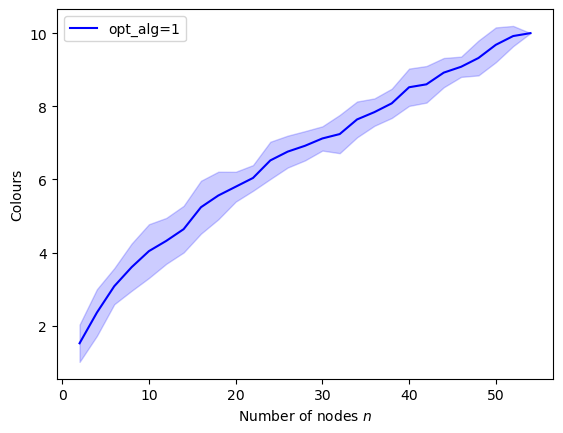

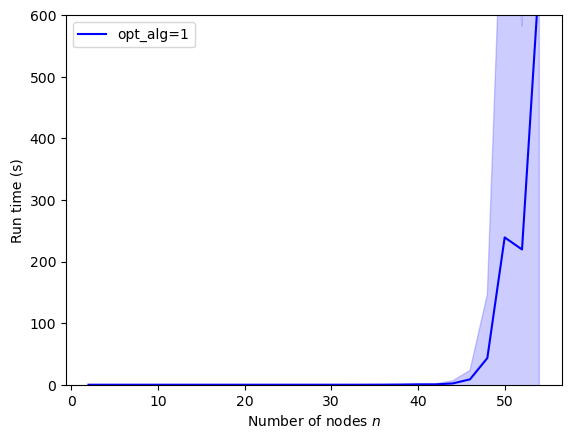

In [13]:
results = []
nVals = range(2,55,2)
for n in nVals:
    for seed in range(25):
        G = nx.gnp_random_graph(n, 0.5, seed)
        start = time.time()
        c = gcol.node_coloring(G, opt_alg=1)
        results.append([n, seed, "opt_alg=1", max(c.values()) + 1, time.time()-start])
        
# Create a pandas datafram from this list and make a pivot 
df = pd.DataFrame(results, columns=["n", "seed", "alg", "cols", "time"])
pivot = df.pivot_table(columns='alg', aggfunc=['mean','std'], values=['cols','time'], index='n')

# Use the pivot table above to make the charts as before
mean1, SD1 = pivot[("mean","cols","opt_alg=1")], pivot[("std","cols","opt_alg=1")]
plt.plot(nVals, mean1, linestyle='-', linewidth=1.5, color="b", label='opt_alg=1')
plt.fill_between(nVals, mean1-SD1, mean1+SD1, color='b', alpha=0.2)
plt.xlabel("Number of nodes $n$")
plt.ylabel("Colours")
plt.legend()
plt.show()

mean1, SD1 = pivot[("mean","time","opt_alg=1")], pivot[("std","time","opt_alg=1")]
plt.plot(nVals, mean1, linestyle='-', linewidth=1.5, color="b", label='opt_alg=1')
plt.fill_between(nVals, mean1-SD1, mean1+SD1, color='b', alpha=0.2)
plt.xlabel("Number of nodes $n$")
plt.ylim((0, 600))
plt.ylabel("Run time (s)")
plt.legend()
plt.show()

The first chart above shows the chromatic numbers from a sample of $G(n,0.5)$ graphs for an increasing number of nodes $n$. It can be seen that the chromatic number rises in a close-to-linear fashion in relation to $n$. The second figure also demonstrates the disadvantages of using an exponential-time algorithm: once $n$ is increased beyond a moderately small value (approximately 50 here), run times become too high and/or unpredictable for practical use. Note, however, that the specific $n$-values that give in these infeasible run times can vary considerably depending on the topology of the graph. For example, planar graphs and scale-free graphs can often be solved very quickly for graphs with several hundred nodes. These sorts of results will usually need to be confirmed empirically. 

## Equitable Coloring

In the equitable node-coloring problem, we are interested in coloring the nodes with a user-defined number of colors $k$ so that (a) adjacent nodes have different colors, and (b) the number of nodes in each color is as equal as possible. The following trials run the ``gcol.equitable_node_k_coloring()`` method on a sample of random $G(500,0.5)$ graphs over a range of suitable $k$-values. The reported cost is simply the difference in size between the largest and smallest color classes in a solution. Hence, if $k$ is a divisor of $n$, a cost of zero indicates an equitable $k$-coloring, else a cost of one indicates an equitable coloring. 

mean                 std          
         cost      time      cost      time
alg opt_alg=2 opt_alg=2 opt_alg=2 opt_alg=2
k                                          
70       2.06  1.392196  0.313636  1.191423
71       2.02  1.315562  0.141421  1.189239
72       2.00  0.930378  0.000000  0.755660
73       1.86  0.844038  0.350510  0.565452
74       1.52  0.650470  0.504672  0.117768
..        ...       ...       ...       ...
295      1.00  3.110134  0.000000  0.037128
296      1.00  3.130134  0.000000  0.032748
297      1.00  3.153672  0.000000  0.038234
298      1.00  3.182735  0.000000  0.038982
299      1.00  3.199719  0.000000  0.040702

[230 rows x 4 columns]

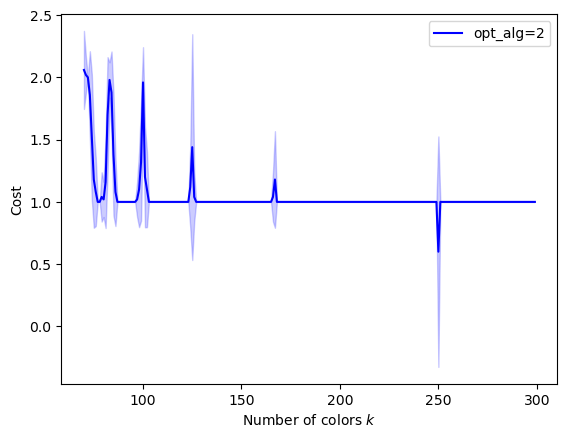

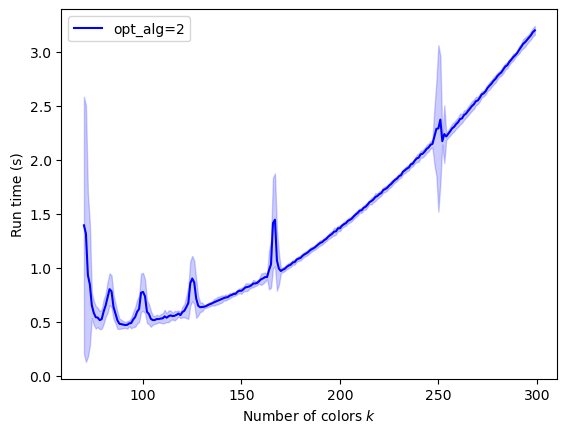

In [4]:
results = []
n = 500
kVals = range(70, 300, 1)
for seed in range(50):
    G = nx.gnp_random_graph(n, 0.5, seed)
    for k in kVals:
        start = time.time()
        c = gcol.equitable_node_k_coloring(G, k, opt_alg=2, it_limit=len(G))
        P = gcol.partition(c)
        cost = max(len(j) for j in P) - min(len(j) for j in P)
        results.append([k, seed, "opt_alg=2", cost, time.time()-start])

# Create a pandas dataframe from this list and make a pivot table
df = pd.DataFrame(results, columns=["k", "seed", "alg", "cost", "time"])
pivot = df.pivot_table(columns='alg', aggfunc=['mean','std'], values=['cost','time'], index='k')
display(pivot)

# Use the pivot table above to make charts as before
mean1, SD1 = pivot[("mean","cost","opt_alg=2")], pivot[("std","cost","opt_alg=2")]
plt.plot(kVals, mean1, linestyle='-', linewidth=1.5, color="b", label='opt_alg=2')
plt.fill_between(kVals, mean1-SD1, mean1+SD1, color='b', alpha=0.2)
plt.xlabel("Number of colors $k$")
plt.ylabel("Cost")
plt.legend()
plt.show()

mean1, SD1 = pivot[("mean","time","opt_alg=2")], pivot[("std","time","opt_alg=2")]
plt.plot(kVals, mean1, linestyle='-', linewidth=1.5, color="b", label='opt_alg=2')
plt.fill_between(kVals, mean1-SD1, mean1+SD1, color='b', alpha=0.2)
plt.xlabel("Number of colors $k$")
plt.ylabel("Run time (s)")
plt.legend()
plt.show()

The first chart above demonstrates that the ``gcol.equitable_node_k_coloring()`` method consistently achieves equitable node $k$-colorings. The exceptions occur for low values of $k$ (which are close to the chromatic number) and when $k$ is a divisor of $n$. In the former case, the low number of available colors restricts the choice of appropriate colors for each node, often leading to inequitable colorings. On the other hand, when $k$ is a divisor of $n$, the algorithm is seeking a solution with a cost of zero, meaning that each color class must have *exactly* the same number of nodes. If this cannot be done, then a cost of at least two must be incurred. 

The second chart above also indicates that runtimes of this routine increase slightly when $k$ is a divisor of $n$. Run times also lengthen due to increases in $k$. The latter is due to the larger number of solutions that need to be evaluated in each iteration of the local search algorithm used with this routine. More details on this algorithm can be found in ``gcol``'s documentation. 

Finally, note that NetworkX also [features](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.coloring.equitable_color.html) an equitable node $k$-coloring routine, but this can only be used when $k\geq \Delta(G)$, where $\Delta(G)$ is the highest node degree in the graph. In the $G(500,0.5)$ graphs considered here, the minimum valid value for $k$ is approximately 280.

## Independent Set Comparison

Our final set or trials looks at the performance the ``gcol.max_independent_set()`` routine and compares it to the [approximation algorithm](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.approximation.clique.maximum_independent_set.html) included in NetworkX for the same problem. As before, we use an iteration limit of $n$ for the former.

mean                                    std                      \
      size               time                size                time   
alg   gcol networkx      gcol  networkx      gcol  networkx      gcol   
n                                                                       
50    7.26     6.18  0.001903  0.012434  0.443087  0.522553  0.004685   
100   8.66     7.46  0.005674  0.059977  0.626295  0.542481  0.007545   
150   9.46     8.08  0.015010  0.159122  0.503457  0.633745  0.003096   
200  10.22     8.58  0.024277  0.327061  0.545482  0.498569  0.007783   
250  10.58     8.92  0.041264  0.572276  0.574634  0.488229  0.007566   
300  10.96     9.28  0.060024  0.929584  0.493219  0.453557  0.007967   
350  11.18     9.68  0.080014  1.398700  0.437526  0.586933  0.007499   
400  11.52     9.86  0.104997  1.991064  0.543609  0.452205  0.007658   
450  11.70    10.18  0.131589  2.724932  0.543984  0.522553  0.007824   
500  12.00    10.38  0.161875  3.609545  0.494872  0.530306  0.007575   

               
               
alg  networkx  
n              
50   0.006328  
100  0.005775  
150  0.011683  
200  0.011075  
250  0.027020  
300  0.020480  
350  0.023576  
400  0.036276  
450  0.048998  
500  0.040481

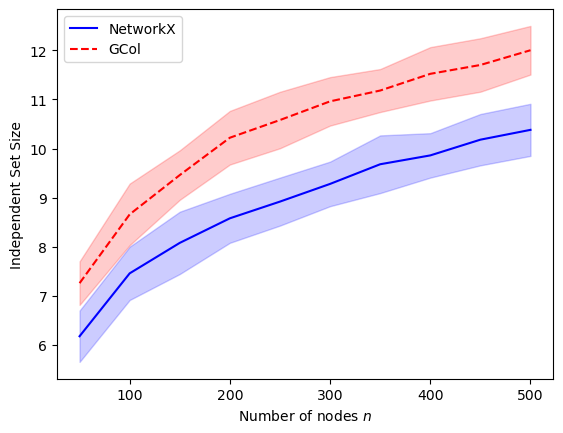

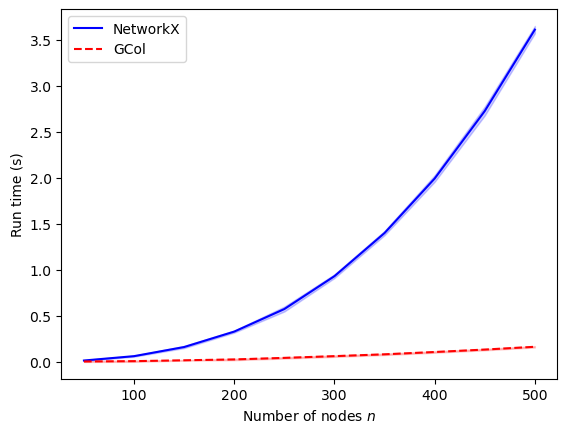

In [5]:
#Carry out the trials and put the results into a list
results = []
nVals = range(50,501,50)
for n in nVals:
    for seed in range(50):
        G = nx.gnp_random_graph(n, 0.5, seed)
        start = time.time()
        S = gcol.max_independent_set(G, it_limit=len(G))
        results.append([n, seed, "gcol", len(S), time.time()-start])
        start = time.time()
        S = nx.approximation.maximum_independent_set(G)
        results.append([n, seed, "networkx", len(S), time.time()-start])
        
# Create a pandas dataframe from this list and make a pivot table
df = pd.DataFrame(results, columns=["n", "seed", "alg", "size", "time"])
pivot = df.pivot_table(columns='alg', aggfunc=['mean','std'], values=['size','time'], index='n')
display(pivot)

# Create the charts as before
mean1, SD1 = pivot[("mean","size","networkx")], pivot[("std","size","networkx")]
mean2, SD2 = pivot[("mean","size","gcol")], pivot[("std","size","gcol")]
plt.plot(nVals, mean1, linestyle='-', linewidth=1.5, color="b", label='NetworkX')
plt.fill_between(nVals, mean1-SD1, mean1+SD1, color='b', alpha=0.2)
plt.plot(nVals, mean2, linestyle='--', linewidth=1.5, color="r", label='GCol')
plt.fill_between(nVals, mean2-SD2, mean2+SD2, color='r', alpha=0.2)
plt.xlabel("Number of nodes $n$")
plt.ylabel("Independent Set Size")
plt.legend()
plt.show()

mean1, SD1 = pivot[("mean","time","networkx")], pivot[("std","time","networkx")]
mean2, SD2 = pivot[("mean","time","gcol")], pivot[("std","time","gcol")]
plt.plot(nVals, mean1, linestyle='-', linewidth=1.5, color="b", label='NetworkX')
plt.fill_between(nVals, mean1-SD1, mean1+SD1, color='b', alpha=0.2)
plt.plot(nVals, mean2, linestyle='--', linewidth=1.5, color="r", label='GCol')
plt.fill_between(nVals, mean2-SD2, mean2+SD2, color='r', alpha=0.2)
plt.xlabel("Number of nodes $n$")
plt.ylabel("Run time (s)")
plt.legend()
plt.show()        

The results above show clearly that the ``gcol.max_independent_set()`` routine produces larger independent sets (and therefore better quality solutions) in less run time. As before, further improvements in solution quality (but longer run times) may also be found by increasing the ``it_limit`` parameter. 